In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
#from ipywidgets import interact
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor

<h2>Table of Contents</h2>
<ul>
    <li><a href="#ref1">1 day prediction with Linear Regression</a></li>
    <li><a href="#ref2">7 days prediction with Random Linear Regression</a></li>
    <li><a href="#ref3">7 days prediction with Ridge Regression</a></li>
    <li><a href="#ref4">7 days prediction with Random Forest Regressor</a></li>
    <li><a href="#ref5">Final:7 days all models</a></li>
</ul>


In [2]:
df = pd.read_csv("Daily_Gold_Price_on_World.csv")

In [3]:
df.head()

,Date,US dollar (USD),Euro (EUR),Japanese yen (JPY),Pound sterling (GBP),Canadian dollar (CAD),Swiss franc (CHF),Indian rupee (INR),Chinese renmimbi (CNY),Turkish lira (TRY),Saudi riyal (SAR),Indonesian rupiah (IDR),UAE dirham (AED),Thai baht THB),Vietnamese dong (VND),Egyptian pound (EGP),Korean won (KRW),Russian ruble (RUB),South African rand (ZAR),Australian dollar (AUD)
0,1979-01-01,226.00,137.06,0.00,110.70,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00
1,1979-01-02,226.80,137.29,43164.91,111.45,263.74,359.62,1792.85,0.0,0.0,735.60,138160.45,851.29,4454.55,0.0,0.0,107470.04,0.0,194.56,193.61
2,1979-01-03,218.60,134.01,43717.90,107.98,264.39,365.87,1802.15,0.0,0.0,739.42,138877.01,855.71,4477.66,0.0,0.0,108027.43,0.0,192.23,192.97
3,1979-01-04,223.15,136.79,43674.89,110.66,264.14,366.38,1811.74,0.0,0.0,743.36,139616.26,860.26,4501.49,0.0,0.0,108602.47,0.0,193.01,194.55
4,1979-01-05,225.50,138.35,44582.47,111.63,268.39,373.72,1843.57,0.0,0.0,756.42,142069.10,875.38,4580.57,0.0,0.0,110510.44,0.0,196.40,197.94


In [4]:
df['Date']=pd.to_datetime(df["Date"])

In [5]:
df=df[["Date","US dollar (USD)"]]

In [6]:
df.rename(columns={"US dollar (USD)":"oz_price_usd"},inplace=True)

In [7]:
df.set_index("Date",inplace=True)

In [8]:
df=df.resample("D").sum()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15804 entries, 1979-01-01 to 2022-04-08
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   oz_price_usd  15804 non-null  float64
dtypes: float64(1)
memory usage: 246.9 KB


In [10]:
df.describe()

,oz_price_usd
count,15804.000000
mean,507.903483
std,524.532997
min,0.000000
25%,0.000000
50%,369.100000
75%,664.812500
max,2067.150000


<AxesSubplot:xlabel='Date'>

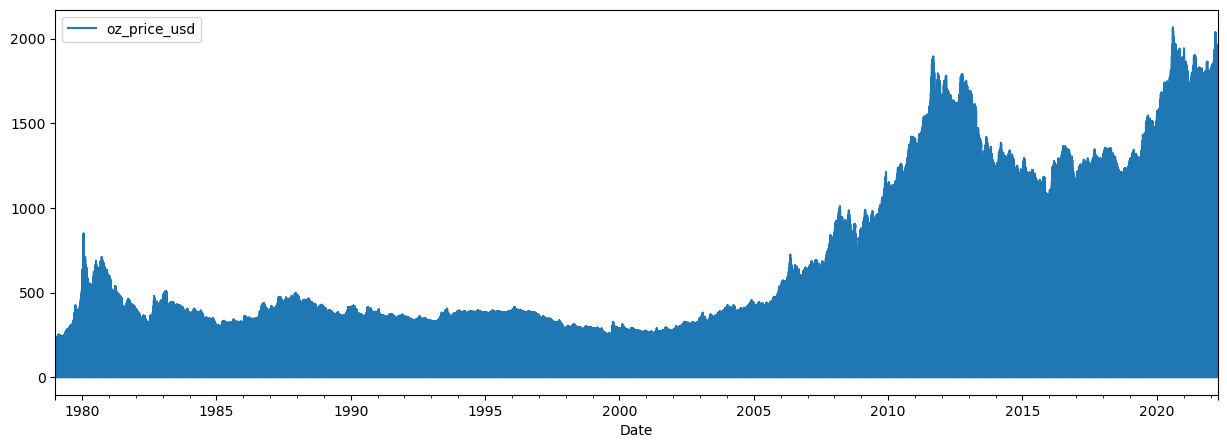

In [11]:
df.plot(figsize=(15,5))

<h5 style="color:black">the data has a lot of zeros so i am gonna replace them with the previous day value beacuse gold price is stable</h5>

In [12]:
df["oz_price_usd"].replace(0,method="ffill",inplace=True)

In [13]:
df[df["oz_price_usd"]==0].count()

oz_price_usd    0
dtype: int64

<AxesSubplot:xlabel='Date'>

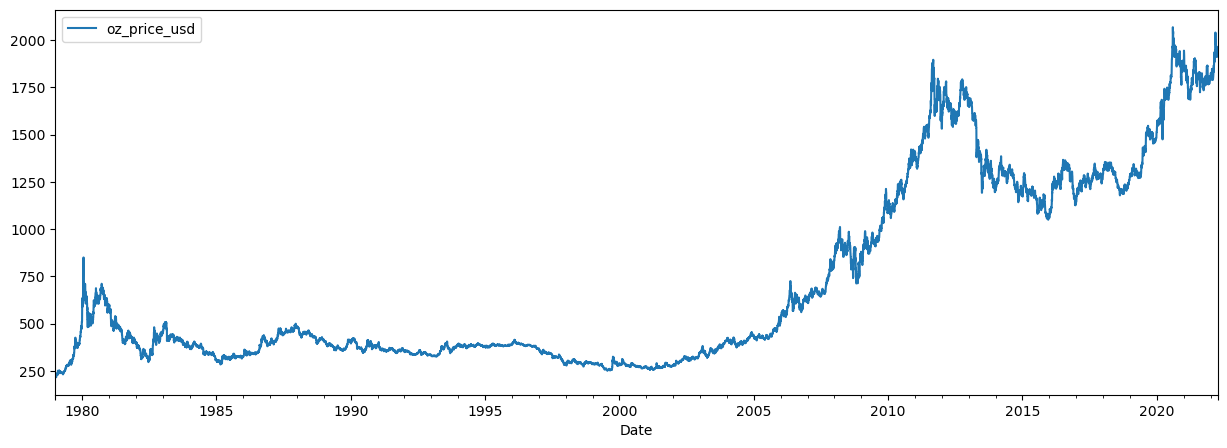

In [14]:
df.plot(figsize=(15,5))

<h1 align=center style="color:red">one-step forecasting</h1>

<h2 id="ref1">model 1:1 day with Linear Regression</h2>

In [15]:
class days_before(BaseEstimator, TransformerMixin):
    def __init__(self,db=5):
        self.db=db
    
    def fit(self,x):
            return self
 
    def transform(self,x):
        lisx=[]
        lisy=[]
        lisx.clear()
        lisy.clear()
        df=x
        for i in range(len(df["oz_price_usd"])):
            
            if i < self.db:
                pass
            else:
                lisx.append(np.array(df["oz_price_usd"][i-self.db:i]))
                #lisy.append([df.index[i],df["oz_price_usd"][i]])
        df_features=np.array(lisx)
        df_target=df[["oz_price_usd"]][int(self.db):]
        #df_target.rename(columns={0:"Date",1:"oz_price_usd"},inplace=True)
        x=df_features
        
        y=df_target
        return x,y


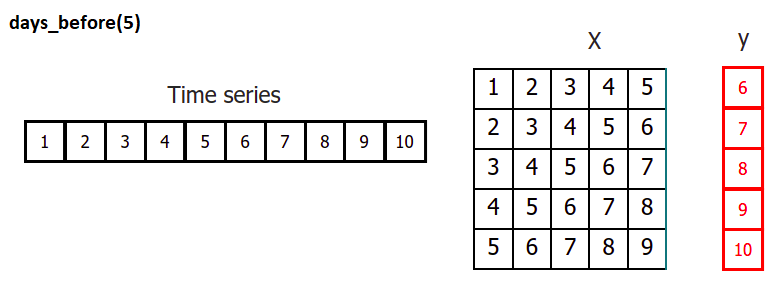

In [16]:
lags=days_before(3)

In [17]:

x,y=lags.fit_transform(df)


<h5 style="color:black">now i have y(the day) as dependent variables and x(the 3 days before) as independent variables</h5>

In [18]:
split=int(len(x)*0.30)

In [19]:
x_train=x[:-split].copy()
x_test=x[-split:].copy()
y_train=y[:-split].copy()
y_test=y[-split:].copy()

In [20]:
input=[('scaler',StandardScaler()),('polynomial',PolynomialFeatures()),('model',LinearRegression())]
pipe=Pipeline(input)
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'polynomial', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'model__copy_X', 'model__fit_intercept', 'model__n_jobs', 'model__normalize', 'model__positive'])

In [21]:
parameters= ([{'scaler':['passthrough', StandardScaler()],
              'polynomial__degree':[1,2,3,4],
              'polynomial__include_bias':[True,False]}])

In [22]:
grid = GridSearchCV(pipe,parameters)

In [23]:
grid.fit(x_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             param_grid=[{'polynomial__degree': [1, 2, 3, 4],
                          'polynomial__include_bias': [True, False],
                          'scaler': ['passthrough', StandardScaler()]}])

In [24]:
grid.best_estimator_

Pipeline(steps=[('scaler', 'passthrough'),
                ('polynomial', PolynomialFeatures(degree=1)),
                ('model', LinearRegression())])

In [25]:
y_test['predicted']=grid.predict(x_test)

In [26]:
r2_score(y_test['oz_price_usd'],y_test['predicted'])

0.9976526302504038

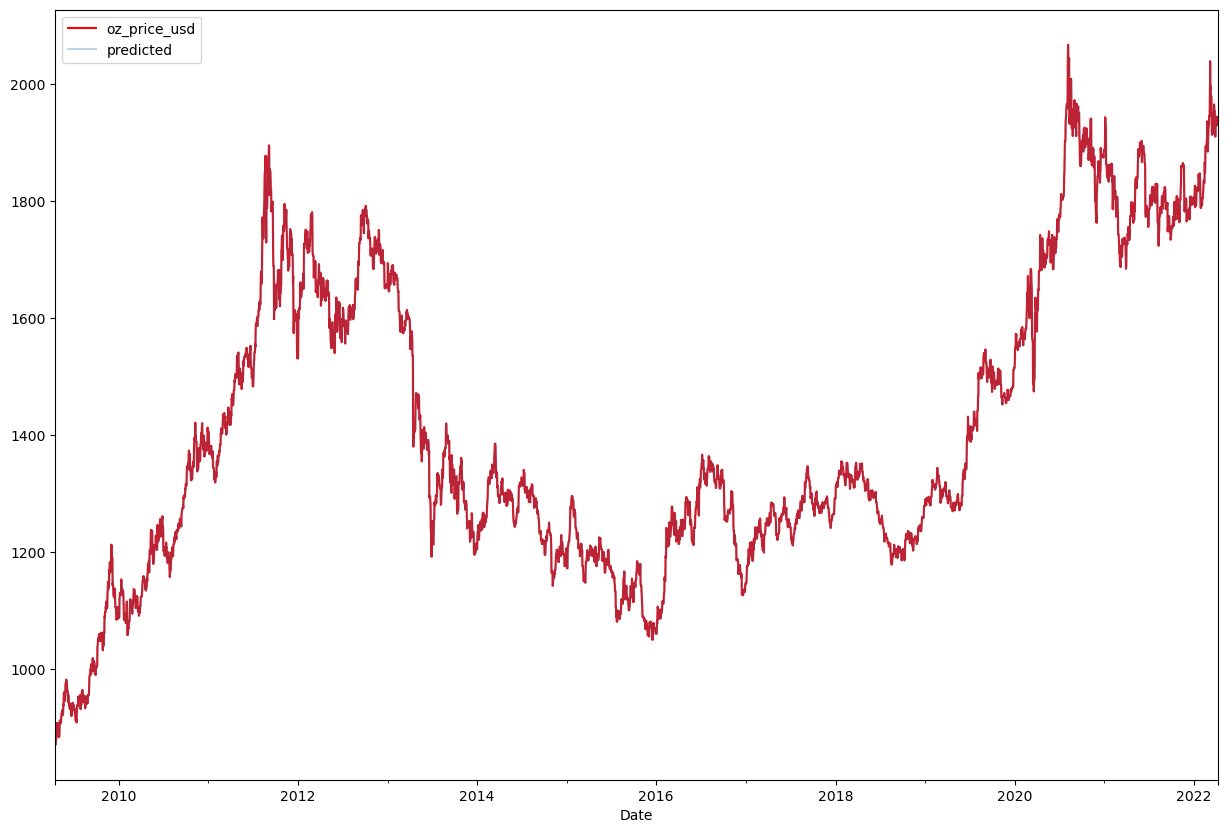

In [27]:
fig,ax= plt.subplots(figsize=(15,10))
#y_train.plot(ax=ax)
y_test['oz_price_usd'].plot(ax=ax,color='red')
y_test['predicted'].plot(ax=ax,alpha=.3)
plt.legend()

<h1 align=center style="color:red">Recursive multi-step forecasting</h1>

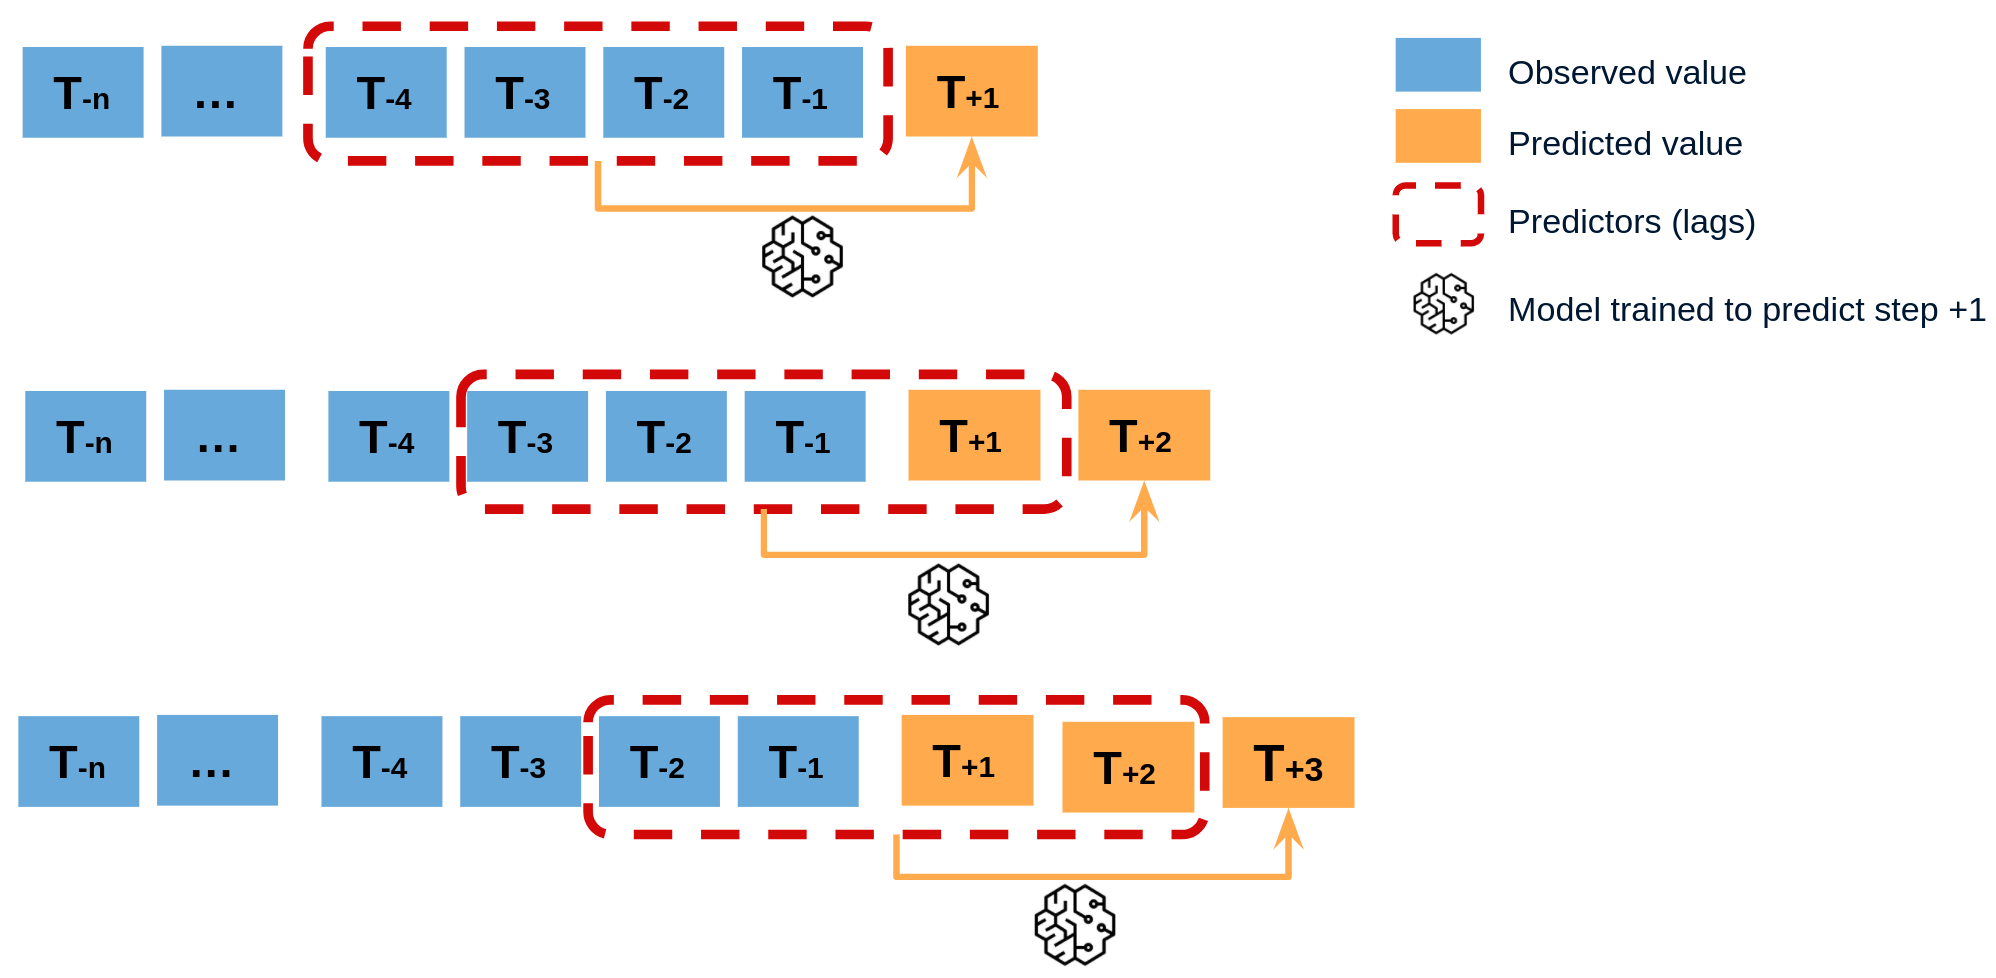

<h5 style="color:black">make the data smaler so my pc could handle it</h5>

In [28]:
df=df[df.index >= '2021-01-01']

<h2 id="ref2" style="color:blue">model 2:7 days with Linear Regression</h2>

In [29]:
input=[('scaler',StandardScaler()),('polynomial',PolynomialFeatures()),('model',LinearRegression())]
pipe=Pipeline(input)
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'polynomial', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'model__copy_X', 'model__fit_intercept', 'model__n_jobs', 'model__normalize', 'model__positive'])

In [30]:
parameters= ([{'scaler':['passthrough', StandardScaler()],
              'polynomial__degree':[1,2],
              'polynomial__include_bias':[True,False]}])

In [31]:
forcaster = ForecasterAutoreg(regressor=pipe,lags=6)

In [32]:
lags_grid = [3,7,10]

In [33]:
step=7

In [34]:
train_df=df[:-step].copy()

In [35]:
test_df=df[-step:].copy()

In [ ]:
results_grid = grid_search_forecaster(forecaster=forcaster,y=train_df['oz_price_usd'],steps=step,
                                    initial_train_size = int(len(train_df)*0.7),metric= 'mean_squared_error',
                                    lags_grid = lags_grid,param_grid=parameters,return_best= True)

In [37]:
results_grid.head(2)

,lags,params,mean_squared_error,polynomial__degree,polynomial__include_bias,scaler
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'polynomial__degree': 1, 'polynomial__include...",640.858591,1,True,passthrough
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'polynomial__degree': 1, 'polynomial__include...",640.858591,1,True,StandardScaler()


<h5 style="color:black">setting the best_params as params and best_lags as lags</h5>

In [38]:
params=results_grid['params'].iloc[0]

In [39]:
lags=int(results_grid['lags'].iloc[0][-1])

In [40]:
forcaster = ForecasterAutoreg(regressor=pipe.set_params(**params),lags=lags)

In [41]:
forcaster.fit(y=train_df['oz_price_usd'])

In [42]:
lr_pred=forcaster.predict(steps=step)

In [43]:
mean_squared_error(test_df,lr_pred)

206.53175441028785

In [44]:
def compare(predicted):
    fig,ax=plt.subplots(figsize=(12,6))    
    test_df.plot(ax=ax)
    predicted.plot(label=str(pipe['model']),ax=ax)
    plt.ylim(1800,2000)
    plt.legend()

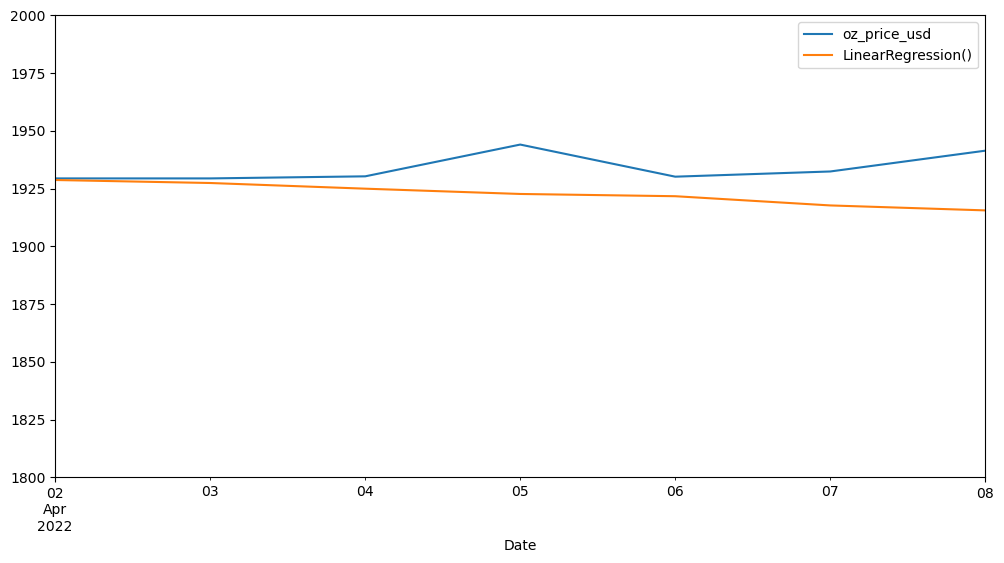

In [45]:
compare(lr_pred)

<h2 id="ref3" style="color:blue"> model 3:7 days with Ridge Regression</h2>

In [46]:
input=[('scaler',StandardScaler()),('polynomial',PolynomialFeatures()),('model',Ridge())]
pipe=Pipeline(input)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'polynomial', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'model__alpha', 'model__copy_X', 'model__fit_intercept', 'model__max_iter', 'model__normalize', 'model__positive', 'model__random_state', 'model__solver', 'model__tol'])

In [47]:
parameters= ([{'scaler':['passthrough', StandardScaler()],
              'polynomial__degree':[1,2],
              'polynomial__include_bias':[True,False],
              'model__alpha':[0,0.1,0.01,0.001,0.0001,0.00001,10,100,1000,10000,100000,1000000,10000000]}])

In [48]:
forcaster = ForecasterAutoreg(regressor=pipe,lags=6)

In [ ]:
results_grid = grid_search_forecaster(forecaster=forcaster,y=train_df['oz_price_usd'],steps=step,
                                    initial_train_size = int(len(train_df)*0.7),metric= 'mean_squared_error',
                                    lags_grid = lags_grid,param_grid=parameters,return_best= True)

In [50]:
results_grid.head(2)

,lags,params,mean_squared_error,model__alpha,polynomial__degree,polynomial__include_bias,scaler
100,"[1, 2, 3]","{'model__alpha': 10000000, 'polynomial__degree...",540.046039,10000000.0,2,True,passthrough
102,"[1, 2, 3]","{'model__alpha': 10000000, 'polynomial__degree...",540.046039,10000000.0,2,False,passthrough


<h5 style="color:black">setting the best_params as params and best_lags as lags</h5>

In [51]:
params=results_grid['params'].iloc[0]

In [52]:
lags=int(results_grid['lags'].iloc[0][-1])

In [53]:
forcaster = ForecasterAutoreg(regressor=pipe.set_params(**params),lags=lags)

In [54]:
forcaster.fit(y=train_df['oz_price_usd'])

In [55]:
ridge_pred=forcaster.predict(steps=step)

In [56]:
mean_squared_error(test_df,ridge_pred)

73.9785505743466

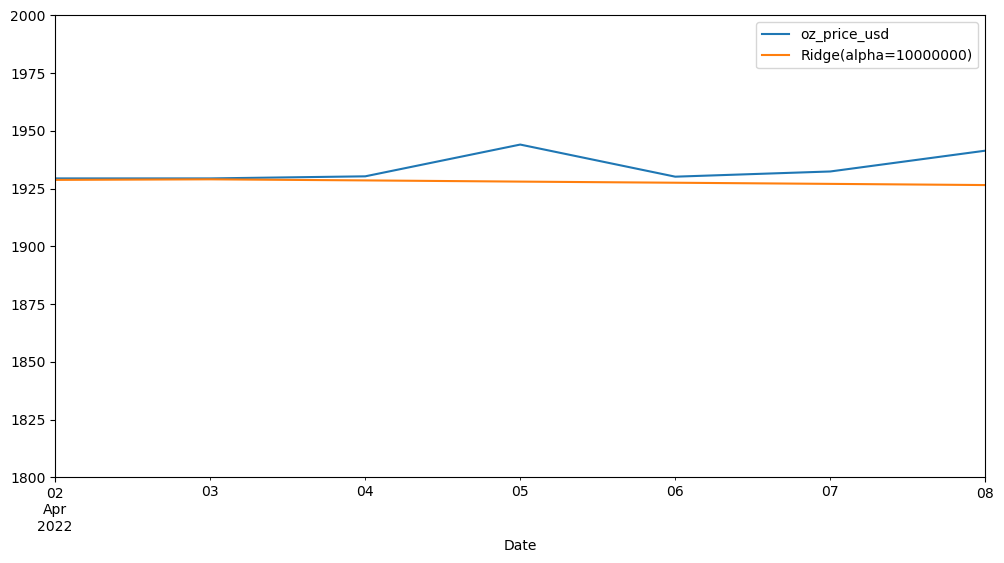

In [57]:
compare(ridge_pred)

<h2 id="ref4" style="color:blue">model 4:7 days with Random Forest Regressor</h2>

In [58]:
input=[('scaler',StandardScaler()),('polynomial',PolynomialFeatures()),('model',RandomForestRegressor(random_state=1))]
pipe=Pipeline(input)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'polynomial', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'polynomial__degree', 'polynomial__include_bias', 'polynomial__interaction_only', 'polynomial__order', 'model__bootstrap', 'model__ccp_alpha', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

In [59]:
parameters= ([{'scaler':['passthrough', StandardScaler()],
            'polynomial__degree':[1,2,3,4,5],'polynomial__include_bias':[True,False],
            'model__max_depth':[3,5,10],'model__n_estimators':[50,100,500]}])

In [60]:
forcaster = ForecasterAutoreg(regressor=pipe,lags=6)

In [ ]:
results_grid = grid_search_forecaster(forecaster=forcaster,
                                    y=train_df['oz_price_usd'],
                                    steps=step,initial_train_size = int(len(train_df)*0.7),
                                    metric= 'mean_squared_error',lags_grid = lags_grid,
                                    param_grid=parameters,return_best=True)

In [73]:
results_grid.head(2)

,lags,params,mean_squared_error,model__max_depth,model__n_estimators,polynomial__degree,polynomial__include_bias,scaler
12,"[1, 2, 3]","{'model__max_depth': 3, 'model__n_estimators':...",1081.134044,3,50,4,True,passthrough
18,"[1, 2, 3]","{'model__max_depth': 3, 'model__n_estimators':...",1081.210098,3,50,5,False,passthrough


<h5 style="color:black">setting the best_params as params and best_lags as lags</h5>

In [74]:
params=results_grid.iloc[0]['params']

In [75]:
lags=int(results_grid['lags'].iloc[0][-1])

In [76]:
forcaster = ForecasterAutoreg(regressor=pipe.set_params(**params),lags=lags)

In [77]:
forcaster.fit(y=train_df['oz_price_usd'])

In [67]:
freg_pred=forcaster.predict(steps=step)

In [78]:
mean_squared_error(test_df,freg_pred)

33.60516204700263

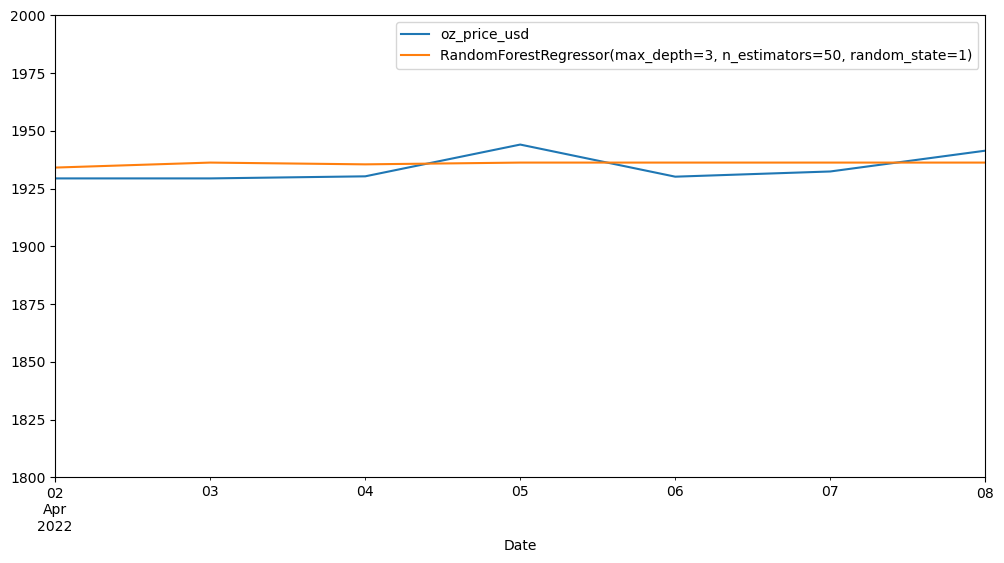

In [79]:
compare(freg_pred)

<h2 id="ref5" style="color:blue">Final:7 days (all models)</h2>

In [82]:
final_df=test_df

In [83]:
final_df['linear']=lr_pred
final_df['ridge']=ridge_pred
final_df['random_forest']=freg_pred

In [85]:
final_df.rename(columns={'oz_price_usd':'oz_price_usd (true)'},inplace=True)

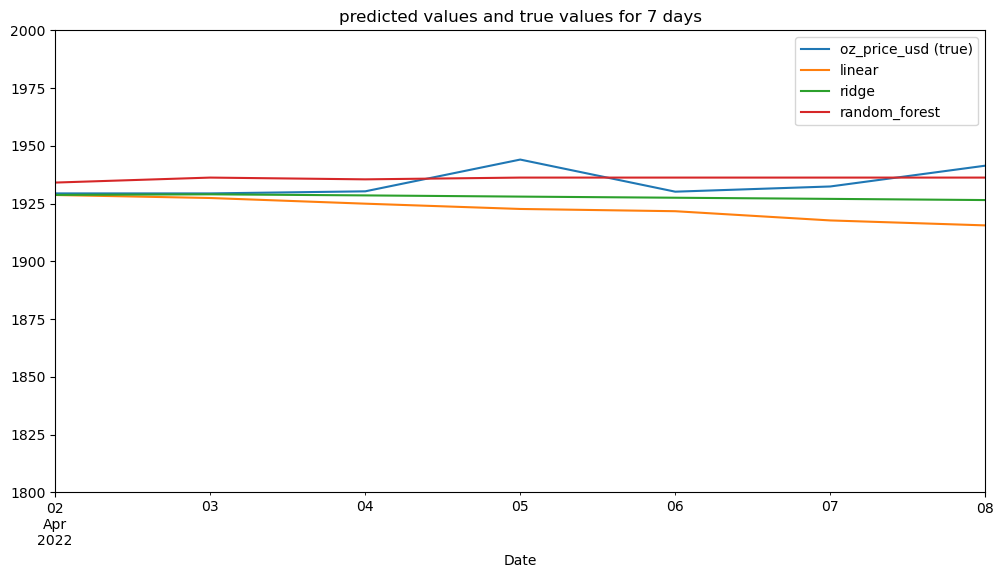

In [86]:
final_df.plot(figsize=(12,6))
plt.ylim(1800,2000)
plt.title('predicted values and true values for 7 days')
plt.show()

In [87]:
final_df.to_csv('final.csv',index=False)